
# 01 — Vélib' GBFS · System Info, Feeds, Snapshot & Quick Checks

Ce notebook utilise les **endpoints officiels** Vélib' Métropole :  
- `system_information.json` → nom du système & **fuseau horaire**  
- `gbfs.json` → liste des **flux disponibles**  
- `station_information.json` → caractéristiques **statiques** des stations  
- `station_status.json` → **statut temps réel** des stations

Il fusionne les infos, calcule `fill_rate`, ajoute des timestamps (UTC et **local** selon le fuseau du système), et sauvegarde un **snapshot Parquet** dans `data/raw/velib/snapshots/`.


In [35]:

from __future__ import annotations

import time
import datetime as dt
from pathlib import Path
from typing import Dict, Any, Optional

import requests
import pandas as pd
import numpy as np

try:
    from zoneinfo import ZoneInfo  # Python 3.9+
except Exception:
    ZoneInfo = None

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


## Configuration

In [36]:

# Racine Opendata officielle (fourni par Vélib' Métropole)
VELIB_BASE = "https://velib-metropole-opendata.smovengo.cloud/opendata/Velib_Metropole"

# Dossiers de sortie
OUT_DIR = Path("data/raw/velib")
OUT_DIR_SNAP = OUT_DIR / "snapshots"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR_SNAP.mkdir(parents=True, exist_ok=True)

STATION_INFO_CSV = OUT_DIR / "station_information.csv"
SYSTEM_INFO_JSON = OUT_DIR / "system_information.json"

print("Sortie:", OUT_DIR.resolve())


Sortie: /Users/souhail/Downloads/data/raw/velib


## Fonctions d'aide

In [37]:

def fetch_json(url: str, retries: int = 3, timeout: int = 25) -> Dict[str, Any]:
    """Télécharge un JSON avec quelques retries."""
    last_err: Optional[Exception] = None
    for _ in range(retries):
        try:
            r = requests.get(url, timeout=timeout)
            r.raise_for_status()
            return r.json()
        except Exception as e:
            last_err = e
            time.sleep(1.0)
    raise RuntimeError(f"Failed to fetch {url}: {last_err!r}")


def get_system_information(base: str = VELIB_BASE) -> Dict[str, Any]:
    data = fetch_json(f"{base}/system_information.json")
    meta = {k: data.get(k) for k in ("lastUpdatedOther", "ttl") if k in data}
    sysinfo = data.get("data", {})
    return {"data": sysinfo, "meta": meta}


def get_gbfs_feeds(base: str = VELIB_BASE) -> Dict[str, Any]:
    data = fetch_json(f"{base}/gbfs.json")
    meta = {k: data.get(k) for k in ("lastUpdatedOther", "ttl") if k in data}
    feeds = data.get("data", {}).get("en", {}).get("feeds", [])
    return {"data": feeds, "meta": meta}


def get_station_information(base: str = VELIB_BASE) -> pd.DataFrame:
    data = fetch_json(f"{base}/station_information.json")
    stations = data.get("data", {}).get("stations", [])
    df = pd.DataFrame(stations)
    if "station_id" in df.columns:
        df["id"] = df["station_id"].astype(str)
    else:
        df["id"] = pd.NA
    for col in ["capacity", "lat", "lon", "name"]:
        if col not in df.columns:
            df[col] = pd.NA
    cols = ["id", "name", "lat", "lon", "capacity"]
    if "station_id" in df.columns:
        cols.insert(1, "station_id")
    return df[cols]


def get_station_status(base: str = VELIB_BASE) -> pd.DataFrame:
    data = fetch_json(f"{base}/station_status.json")
    stations = data.get("data", {}).get("stations", [])
    df = pd.DataFrame(stations)

    if "station_id" in df.columns:
        df["id"] = df["station_id"].astype(str)
    else:
        df["id"] = pd.NA

    def pick_col(row, names):
        for n in names:
            if n in row and pd.notna(row[n]):
                return row[n]
        return np.nan

    df["num_bikes_available_norm"] = df.apply(lambda r: pick_col(r, ["num_bikes_available", "numBikesAvailable"]), axis=1)
    df["num_docks_available_norm"] = df.apply(lambda r: pick_col(r, ["num_docks_available", "numDocksAvailable"]), axis=1)

    mech, elec = [], []
    nba_types = df.get("num_bikes_available_types")
    if nba_types is not None:
        for item in nba_types:
            m = e = 0
            if isinstance(item, list):
                for d in item:
                    if isinstance(d, dict):
                        m += int(d.get("mechanical", 0) or 0)
                        e += int(d.get("ebike", 0) or 0)
            elif isinstance(item, dict):
                m = int(item.get("mechanical", 0) or 0)
                e = int(item.get("ebike", 0) or 0)
            mech.append(m)
            elec.append(e)
    else:
        mech = [np.nan] * len(df)
        elec = [np.nan] * len(df)

    df["available_mechanical"] = mech
    df["available_ebike"] = elec

    for col in ["is_installed", "is_renting", "is_returning"]:
        if col not in df.columns:
            df[col] = np.nan

    if "last_reported" in df.columns:
        df["last_reported"] = pd.to_datetime(df["last_reported"], unit="s", errors="coerce", utc=True)

    return df


## `system_information` (nom + fuseau horaire)

In [38]:

sysinfo = get_system_information(VELIB_BASE)
display(sysinfo["data"])
print("Meta:", sysinfo["meta"])

SYSTEM_INFO_JSON.write_text(pd.Series(sysinfo).to_json(), encoding="utf-8")

SYSTEM_TZ = sysinfo["data"].get("timezone", "UTC")
SYSTEM_NAME = sysinfo["data"].get("name", "Velib Metropole")
print("System:", SYSTEM_NAME, "| Timezone:", SYSTEM_TZ)


{'system_id': 'Paris',
 'name': 'Paris',
 'url': '',
 'timezone': 'Europe/Paris',
 'language': 'en'}

Meta: {'lastUpdatedOther': 1762419728, 'ttl': 3600}
System: Paris | Timezone: Europe/Paris


## `gbfs.json` → flux disponibles

In [39]:

feeds = get_gbfs_feeds(VELIB_BASE)
print("Meta:", feeds["meta"])
pd.DataFrame(feeds["data"]).head()


Meta: {'lastUpdatedOther': 1762419728, 'ttl': 3600}


,name,url
0,gbfs,https://velib-metropole-opendata.smovengo.clou...
1,system_information,https://velib-metropole-opendata.smovengo.clou...
2,station_information,https://velib-metropole-opendata.smovengo.clou...
3,station_status,https://velib-metropole-opendata.smovengo.clou...


## Snapshot fusionné (status + information)

In [40]:

def build_snapshot_df(base: str = VELIB_BASE, tzname: str = "UTC") -> pd.DataFrame:
    info = get_station_information(base)
    status = get_station_status(base)

    merged = status.merge(
        info[["id", "name", "lat", "lon", "capacity"]],
        on="id",
        how="left",
    )

    now_utc = pd.to_datetime(dt.datetime.utcnow(), utc=True)
    try:
        if ZoneInfo and tzname:
            now_local = now_utc.tz_convert(ZoneInfo(tzname))
        else:
            now_local = now_utc
    except Exception:
        now_local = now_utc

    merged["ts_utc"] = now_utc
    merged["ts_local"] = now_local

    cap = pd.to_numeric(merged.get("capacity"), errors="coerce")
    bikes = pd.to_numeric(merged.get("num_bikes_available_norm"), errors="coerce")
    with np.errstate(divide="ignore", invalid="ignore"):
        merged["fill_rate"] = np.where(cap > 0, bikes / cap, np.nan)

    preferred = [
        "ts_utc", "ts_local", "id", "name", "lat", "lon", "capacity",
        "num_bikes_available_norm", "num_docks_available_norm",
        "available_mechanical", "available_ebike",
        "is_installed", "is_renting", "is_returning", "last_reported",
        "fill_rate"
    ]
    for c in preferred:
        if c not in merged.columns:
            merged[c] = np.nan

    merged = merged[preferred + [c for c in merged.columns if c not in preferred]]
    return merged


## Prendre un snapshot & sauvegarder (Parquet)

In [41]:

def save_snapshot_parquet(df: pd.DataFrame, out_dir: Path = OUT_DIR_SNAP) -> Path:
    ts = pd.to_datetime(df["ts_utc"].iloc[0])
    stamp = ts.strftime("%Y%m%d_%H%M%S")
    out_path = out_dir / f"velib_snapshot_{stamp}.parquet"
    df.to_parquet(out_path, index=False, engine="pyarrow")
    return out_path

df = build_snapshot_df(VELIB_BASE, tzname=SYSTEM_TZ)
print("Stations:", len(df))
out_path = save_snapshot_parquet(df)
print("Snapshot saved ->", out_path)

df.head()


Stations: 1495
Snapshot saved -> data/raw/velib/snapshots/velib_snapshot_20251106_090219.parquet


/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_47249/2064125257.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now_utc = pd.to_datetime(dt.datetime.utcnow(), utc=True)


,ts_utc,ts_local,id,name,lat,lon,capacity,num_bikes_available_norm,num_docks_available_norm,available_mechanical,available_ebike,is_installed,is_renting,is_returning,last_reported,fill_rate,station_id,num_bikes_available,numBikesAvailable,num_bikes_available_types,num_docks_available,numDocksAvailable,stationCode,station_opening_hours
0,2025-11-06 09:02:19.638418+00:00,2025-11-06 10:02:19.638418+01:00,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,3,31,1,2,1,1,1,2025-11-06 08:35:51+00:00,0.085714,213688169,3,3,"[{'mechanical': 1}, {'ebike': 2}]",31,31,16107,None
1,2025-11-06 09:02:19.638418+00:00,2025-11-06 10:02:19.638418+01:00,19179944124,Hôpital Mondor,48.798922,2.453745,28,13,14,3,10,1,1,1,2025-11-06 08:32:37+00:00,0.464286,19179944124,13,13,"[{'mechanical': 3}, {'ebike': 10}]",14,14,40001,None
2,2025-11-06 09:02:19.638418+00:00,2025-11-06 10:02:19.638418+01:00,18795078746,Charcot - Benfleet,48.878370,2.440524,28,12,14,11,1,1,1,1,2025-11-06 08:28:48+00:00,0.428571,18795078746,12,12,"[{'mechanical': 11}, {'ebike': 1}]",14,14,32304,None
3,2025-11-06 09:02:19.638418+00:00,2025-11-06 10:02:19.638418+01:00,36255,Toudouze - Clauzel,48.879296,2.337360,21,2,18,0,2,1,1,1,2025-11-06 08:36:48+00:00,0.095238,36255,2,2,"[{'mechanical': 0}, {'ebike': 2}]",18,18,9020,None
4,2025-11-06 09:02:19.638418+00:00,2025-11-06 10:02:19.638418+01:00,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25,17,7,12,5,1,1,1,2025-11-06 08:32:53+00:00,0.680000,251039991,17,17,"[{'mechanical': 12}, {'ebike': 5}]",7,7,14111,None


In [23]:
print(df.shape) 
print(df.columns)

(1495, 24)
Index(['ts_utc', 'ts_local', 'id', 'name', 'lat', 'lon', 'capacity', 'num_bikes_available_norm', 'num_docks_available_norm',
       'available_mechanical', 'available_ebike', 'is_installed', 'is_renting', 'is_returning', 'last_reported', 'fill_rate', 'station_id',
       'num_bikes_available', 'numBikesAvailable', 'num_bikes_available_types', 'num_docks_available', 'numDocksAvailable', 'stationCode',
       'station_opening_hours'],
      dtype='object')


In [15]:
df["ts_utc"].nunique()

1

## Sauvegarder `station_information.csv`

In [10]:

info_df = get_station_information(VELIB_BASE)
info_df.to_csv(STATION_INFO_CSV, index=False)
print("Saved ->", STATION_INFO_CSV.resolve())

print(info_df.shape)
info_df.head()

Saved -> /Users/souhail/Downloads/data/raw/velib/station_information.csv
(1495, 6)


,id,station_id,name,lat,lon,capacity
0,213688169,213688169,Benjamin Godard - Victor Hugo,48.865983,2.275725,35
1,19179944124,19179944124,Hôpital Mondor,48.798922,2.453745,28
2,18795078746,18795078746,Charcot - Benfleet,48.878370,2.440524,28
3,36255,36255,Toudouze - Clauzel,48.879296,2.337360,21
4,251039991,251039991,Cassini - Denfert-Rochereau,48.837526,2.336035,25


## Sanity checks (remplissage, top stations)

In [42]:

top_empty = df.sort_values("fill_rate", ascending=True).head(10)[["name","capacity","num_bikes_available_norm","fill_rate"]]
top_full  = df.sort_values("fill_rate", ascending=False).head(10)[["name","capacity","num_bikes_available_norm","fill_rate"]]

display(top_empty.style.format({"fill_rate": "{:.2%}"}))
display(top_full.style.format({"fill_rate": "{:.2%}"}))

ax = df["fill_rate"].dropna().plot(kind="hist", bins=30, alpha=0.85)
ax.set_title("Distribution du taux de remplissage (snapshot)")
ax.set_xlabel("fill_rate")
plt.show()


AttributeError: The '.style' accessor requires jinja2

## Charger plusieurs snapshots (si disponibles)

In [ ]:

snaps = sorted(OUT_DIR_SNAP.glob("velib_snapshot_*.parquet"))
len(snaps), snaps[:3]


In [ ]:

if len(snaps) >= 2:
    all_df = pd.concat([pd.read_parquet(p) for p in snaps], ignore_index=True)
    all_df["ts_utc"] = pd.to_datetime(all_df["ts_utc"], utc=True)
    all_df["ts_local"] = pd.to_datetime(all_df["ts_local"])

    sid = all_df["id"].mode().iloc[0]
    s = all_df.loc[all_df["id"] == sid].sort_values("ts_utc")
    ax = s.set_index("ts_local")["num_bikes_available_norm"].plot()
    ax.set_title(f"Evolution — station {sid}")
    ax.set_ylabel("num_bikes_available")
    plt.show()
else:
    print("Prenez plusieurs snapshots (exécutez la cellule de collecte plusieurs fois) pour des séries temporelles).")



### Notes
- Les champs camelCase/snake_case sont normalisés en `num_bikes_available_norm` et `num_docks_available_norm`.
- `ts_local` utilise le fuseau horaire issu de `system_information.json` (fallback `UTC` si indisponible).
- `available_mechanical` et `available_ebike` proviennent de `num_bikes_available_types` si disponible.
- Les métadonnées top-level `lastUpdatedOther` et `ttl` sont récupérées par les fonctions `get_*` (affichées dans les cellules). 


In [43]:
import io, zipfile, requests, pandas as pd

# ⬇️ Remplace par TON lien GitHub (asset .zip d'une release)
URL = "https://github.com/lovasoa/historique-velib-opendata/releases/download/latest/stations.zip"

r = requests.get(URL, timeout=60)
r.raise_for_status()

# Le zip contient généralement 1 CSV
z = zipfile.ZipFile(io.BytesIO(r.content))
csv_names = [n for n in z.namelist() if n.lower().endswith(".csv")]
assert csv_names, "Aucun CSV trouvé dans l'archive."
df = pd.read_csv(z.open(csv_names[0]), low_memory=False)

print(df.shape)
df.head()


HTTPError: 404 Client Error: Not Found for url: https://github.com/lovasoa/historique-velib-opendata/releases/download/latest/stations.zip

## Historical data 

In [4]:
import io, zipfile, gzip, requests, pandas as pd

OWNER = "lovasoa"
REPO  = "historique-velib-opendata"

# 1) On tente d'abord des URLs "stables"
CANDIDATES = [
    f"https://github.com/{OWNER}/{REPO}/releases/latest/download/stations.zip",
    f"https://github.com/{OWNER}/{REPO}/releases/latest/download/stations.csv.zip",
    f"https://github.com/{OWNER}/{REPO}/releases/latest/download/stations.csv",
    f"https://github.com/{OWNER}/{REPO}/releases/latest/download/stations.csv.gz",
]

headers = {"User-Agent": "velib-notebook/1.0"}  # GitHub aime bien un User-Agent explicite

def try_download(url):
    r = requests.get(url, headers=headers, timeout=60)
    if r.status_code == 200:
        return r
    return None

resp = None
chosen_url = None
for url in CANDIDATES:
    resp = try_download(url)
    if resp:
        chosen_url = url
        break

# 2) Si rien trouvé, on interroge l'API GitHub pour l’asset exact de la dernière release
if not resp:
    api = f"https://api.github.com/repos/{OWNER}/{REPO}/releases/latest"
    j = requests.get(api, headers=headers, timeout=60).json()
    assets = j.get("assets", [])
    # on cherche un asset contenant "stations" et finissant par zip/csv/gz
    for a in assets:
        name = a.get("name", "").lower()
        if "stations" in name and (name.endswith(".zip") or name.endswith(".csv") or name.endswith(".csv.gz")):
            chosen_url = a.get("browser_download_url")
            resp = requests.get(chosen_url, headers=headers, timeout=60)
            if resp.status_code == 200:
                break

if not resp:
    raise RuntimeError("Impossible de trouver/télécharger l'archive des stations (release latest).")

print("Téléchargé depuis :", chosen_url)

# 3) Lecture du contenu -> DataFrame
content = resp.content
df = None

if chosen_url.endswith(".zip"):
    z = zipfile.ZipFile(io.BytesIO(content))
    csv_names = [n for n in z.namelist() if n.lower().endswith(".csv")]
    assert csv_names, "Aucun CSV dans le zip."
    df = pd.read_csv(z.open(csv_names[0]), low_memory=False)

elif chosen_url.endswith(".csv.gz"):
    df = pd.read_csv(io.BytesIO(gzip.decompress(content)), low_memory=False)

elif chosen_url.endswith(".csv"):
    df = pd.read_csv(io.BytesIO(content), low_memory=False)

else:
    raise RuntimeError("Format d'asset inattendu. Attendu: .zip / .csv / .csv.gz")

print(df.shape)
df.head()


Téléchargé depuis : https://github.com/lovasoa/historique-velib-opendata/releases/latest/download/stations.zip
(10986729, 7)


,2020-11-26T12:59Z,35,4,5,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True
0,2020-11-26T12:59Z,55,23,4,André Mazet - Saint-André des Arts,"48.85376,2.33910",True
1,2020-11-26T12:59Z,20,0,0,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True
2,2020-11-26T12:59Z,21,0,1,Toudouze - Clauzel,"48.87930,2.33736",True
3,2020-11-26T12:59Z,30,3,1,Mairie du 12ème,"48.84086,2.38755",True
4,2020-11-26T12:59Z,46,18,10,Harpe - Saint-Germain,"48.85152,2.34367",True


In [5]:
# après avoir construit z = zipfile.ZipFile(io.BytesIO(content))
csv_name = [n for n in z.namelist() if n.lower().endswith(".csv")][0]

COLS = [
    "date",
    "capacity",
    "available_mechanical",
    "available_electrical",   # (dans certaines archives: available_ebike)
    "station_name",
    "station_geo",
    "operative",
]

# petit auto-detect si le fichier contient déjà une ligne d'entête "date,capacity,..."
first_line = z.open(csv_name).readline().decode("utf-8").strip().lower()
has_header = first_line.startswith("date,capacity")

if has_header:
    df = pd.read_csv(z.open(csv_name), low_memory=False, parse_dates=["date"])
else:
    df = pd.read_csv(
        z.open(csv_name),
        header=None,          # ⬅️ on dit "pas d'entête"
        names=COLS,           # ⬅️ on impose nos noms
        low_memory=False,
        parse_dates=[0],
    )

df.head()


,date,capacity,available_mechanical,available_electrical,station_name,station_geo,operative
0,2020-11-26 12:59:00+00:00,35,4,5,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True
1,2020-11-26 12:59:00+00:00,55,23,4,André Mazet - Saint-André des Arts,"48.85376,2.33910",True
2,2020-11-26 12:59:00+00:00,20,0,0,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True
3,2020-11-26 12:59:00+00:00,21,0,1,Toudouze - Clauzel,"48.87930,2.33736",True
4,2020-11-26 12:59:00+00:00,30,3,1,Mairie du 12ème,"48.84086,2.38755",True


In [6]:
df.tail()

,date,capacity,available_mechanical,available_electrical,station_name,station_geo,operative
10986725,2021-04-09 14:37:00+00:00,38,4,2,Général Michel Bizot - Claude Decaen,"48.83481,2.40093",True
10986726,2021-04-09 14:37:00+00:00,20,2,1,Ivry - Baudricourt,"48.82470,2.36311",True
10986727,2021-04-09 14:37:00+00:00,39,17,0,Saint-Mandé - Docteur Arnold Netter,"48.84463,2.40495",True
10986728,2021-04-09 14:37:00+00:00,21,12,4,Saint-Marcel - Hôpital,"48.83950,2.36099",True
10986729,2021-04-09 14:37:00+00:00,36,12,5,Guynemer - Jardin du Luxembourg,"48.84661,2.33255",True


In [7]:
df["station_name"].nunique()

1399

In [8]:
# date déjà en datetime (UTC) → local
df["date_paris"] = df["date"].dt.tz_convert("Europe/Paris")

# lat/lon depuis "station_geo"
geo = df["station_geo"].str.split(",", expand=True)
df["lat"] = pd.to_numeric(geo[0], errors="coerce")
df["lon"] = pd.to_numeric(geo[1], errors="coerce")

# dispos & taux de remplissage
df["available_total"] = df[["available_mechanical","available_electrical"]].sum(axis=1, min_count=1)
df["fill_rate"] = df["available_total"] / df["capacity"]
df["hour"] = df["date_paris"].dt.hour
df["weekday"] = df["date_paris"].dt.day_name()

In [9]:
df.head()

,date,capacity,available_mechanical,available_electrical,station_name,station_geo,operative,date_paris,lat,lon,available_total,fill_rate,hour,weekday
0,2020-11-26 12:59:00+00:00,35,4,5,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True,2020-11-26 13:59:00+01:00,48.86598,2.27572,9,0.257143,13,Thursday
1,2020-11-26 12:59:00+00:00,55,23,4,André Mazet - Saint-André des Arts,"48.85376,2.33910",True,2020-11-26 13:59:00+01:00,48.85376,2.33910,27,0.490909,13,Thursday
2,2020-11-26 12:59:00+00:00,20,0,0,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True,2020-11-26 13:59:00+01:00,48.85591,2.39257,0,0.000000,13,Thursday
3,2020-11-26 12:59:00+00:00,21,0,1,Toudouze - Clauzel,"48.87930,2.33736",True,2020-11-26 13:59:00+01:00,48.87930,2.33736,1,0.047619,13,Thursday
4,2020-11-26 12:59:00+00:00,30,3,1,Mairie du 12ème,"48.84086,2.38755",True,2020-11-26 13:59:00+01:00,48.84086,2.38755,4,0.133333,13,Thursday


### 1) Qualité & couverture des données

Pas de trous ? stations avec faible “coverage”.

In [10]:
cover = (df
  .groupby("station_name")["date"]
  .agg(n_points="count", first="min", last="max"))
cover["avg_interval_min"] = (cover["last"]-cover["first"]).dt.total_seconds()/(60*cover["n_points"])
cover.sort_values("n_points").head()

,n_points,first,last,avg_interval_min
station_name,,,,
Hôpital Européen Georges Pompidou,2,2021-04-09 14:25:00+00:00,2021-04-09 14:37:00+00:00,6.000000
Jean Jaurès - Paul Lafargue,2,2021-04-09 14:25:00+00:00,2021-04-09 14:37:00+00:00,6.000000
station formation alfortville,5,2021-03-05 12:53:00+00:00,2021-03-09 16:32:00+00:00,1195.800000
Parmentier - Abel rabaud,612,2020-11-26 12:59:00+00:00,2020-12-03 17:01:00+00:00,16.866013
Arago - Paul Lafargue,680,2021-04-01 14:04:00+00:00,2021-04-09 14:04:00+00:00,16.941176


In [11]:
cover.sort_values("n_points").tail()

,n_points,first,last,avg_interval_min
station_name,,,,
Île de la Jatte,7866,2020-11-26 12:59:00+00:00,2021-04-09 14:37:00+00:00,24.543351
Château - République,15732,2020-11-26 12:59:00+00:00,2021-04-09 14:37:00+00:00,12.271676
Place de l'Europe,15732,2020-11-26 12:59:00+00:00,2021-04-09 14:37:00+00:00,12.271676
Place de l'Eglise,15732,2020-11-26 12:59:00+00:00,2021-04-09 14:37:00+00:00,12.271676
Université,15732,2020-11-26 12:59:00+00:00,2021-04-09 14:37:00+00:00,12.271676


### Changement de capacité au fil du temps (reconfigurations de station).

In [12]:
cap_chg = df.groupby(["station_name","capacity"]).size().reset_index(name="n")
cap_chg[cap_chg.duplicated("station_name", keep=False)].sort_values("station_name").head()


,station_name,capacity,n
72,Bastille - Beaumarchais,23,7858
73,Bastille - Beaumarchais,24,8
188,Centquatre,40,48
189,Centquatre,41,1957
190,Centquatre,42,5861


### 2) Tendances globales

Dispo totale & occupation moyenne dans le temps.

/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_50440/2254065678.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


<Axes: xlabel='date_paris'>

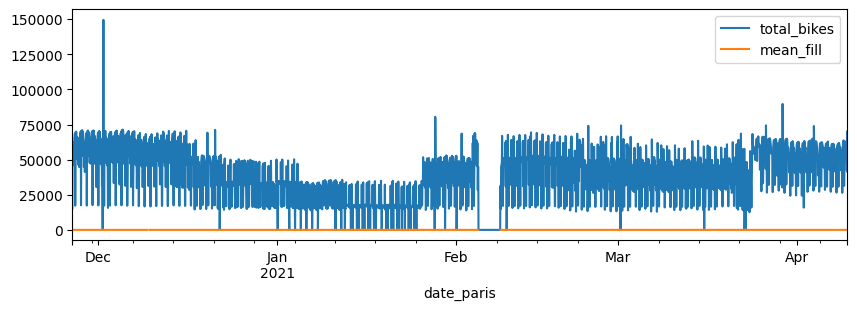

In [13]:
g = (df.set_index("date_paris")
       .resample("1H")
       .agg(total_bikes=("available_total","sum"),
            mean_fill=("fill_rate","mean")))
g.plot(y=["total_bikes","mean_fill"], figsize=(10,3))


Profil journalier semaine vs week-end.

In [15]:
df["is_weekend"] = df["date_paris"].dt.dayofweek >= 5
h = df.groupby(["is_weekend","hour"])["fill_rate"].mean().unstack(0)
h.head()

is_weekend,False,True
hour,,
0,0.386758,0.389102
1,0.384080,0.386691
2,0.387399,0.391798
3,0.390773,0.392547
4,0.391765,0.393164


### 3) Analyses par station

Stations souvent vides/pleines (stress opérationnel).

In [16]:
by_st = df.groupby("station_name").agg(
    fill_mean=("fill_rate","mean"),
    fill_std=("fill_rate","std"),
    p_empty=("available_total", lambda s: (s==0).mean()),
    p_full=("available_total", lambda s: (s==s.max()).mean())
).sort_values("fill_mean")


Variabilité (coefficient de variation) pour trouver les stations “imprévisibles”.

In [17]:
by_st["cv"] = by_st["fill_std"] / by_st["fill_mean"]
by_st.head()

,fill_mean,fill_std,p_empty,p_full,cv
station_name,,,,,
Parc Floral du Bel Air,0.0,0.0,1.0,1.0,NaN
Macdonald - Césaria Evora,0.0,0.0,1.0,1.0,NaN
8 Mai 1945 - 10 Juillet 1940,0.0,0.0,1.0,1.0,NaN
Porte de Pantin - Petits Ponts,0.0,0.0,1.0,1.0,NaN
Gare RER les Ardoines,0.0,0.0,1.0,1.0,NaN


### 4) Mécanique vs Électrique

Part d’e-bikes dans le temps & par station.

In [19]:
df["share_ebike"] = df["available_electrical"] / df["available_total"]
ebike_h = df.groupby("hour")["share_ebike"].mean()
ebike_h

hour
0     0.420354
1     0.415276
2     0.416661
3     0.419751
4     0.417966
5     0.416959
6     0.418397
7     0.415717
8     0.411988
9     0.415062
10    0.417039
11    0.412582
12    0.404172
13    0.403877
14    0.417758
15    0.425522
16    0.428394
17    0.422074
18    0.414916
19    0.401243
20    0.396384
21    0.404541
22    0.420509
23    0.421505
Name: share_ebike, dtype: float64

In [20]:
df.head()

,date,capacity,available_mechanical,available_electrical,station_name,station_geo,operative,date_paris,lat,lon,available_total,fill_rate,hour,weekday,is_weekend,share_ebike
0,2020-11-26 12:59:00+00:00,35,4,5,Benjamin Godard - Victor Hugo,"48.86598,2.27572",True,2020-11-26 13:59:00+01:00,48.86598,2.27572,9,0.257143,13,Thursday,False,0.555556
1,2020-11-26 12:59:00+00:00,55,23,4,André Mazet - Saint-André des Arts,"48.85376,2.33910",True,2020-11-26 13:59:00+01:00,48.85376,2.33910,27,0.490909,13,Thursday,False,0.148148
2,2020-11-26 12:59:00+00:00,20,0,0,Charonne - Robert et Sonia Delauney,"48.85591,2.39257",True,2020-11-26 13:59:00+01:00,48.85591,2.39257,0,0.000000,13,Thursday,False,NaN
3,2020-11-26 12:59:00+00:00,21,0,1,Toudouze - Clauzel,"48.87930,2.33736",True,2020-11-26 13:59:00+01:00,48.87930,2.33736,1,0.047619,13,Thursday,False,1.000000
4,2020-11-26 12:59:00+00:00,30,3,1,Mairie du 12ème,"48.84086,2.38755",True,2020-11-26 13:59:00+01:00,48.84086,2.38755,4,0.133333,13,Thursday,False,0.250000


### 5) Rebalancing / opérations terrain

L’idée : grands sauts dans la dispo ⇒ camion venu charger/décharger.

In [ ]:
# exemple : on regarde la dérivée par station
df = df.sort_values(["station_name","date_paris"])
df["delta"] = df.groupby("station_name")["available_total"].diff()
ops = df[df["delta"].abs() >= 8]  # seuil à ajuster (8 vélos par ex.)

# à adapter en fonction de dt 

### 6) Épisodes “time-to-empty / time-to-full”

Mesurer la durée jusqu’au prochain 0 ou prochain plein (utile pour la planif).

In [23]:
# time-to-empty (simplifié) : prochain timestamp où available_total==0
def time_to_condition(s, cond):
    idx = s.index
    nxt = []
    last_true = None
    for i in range(len(s)-1, -1, -1):
        if cond(s.iloc[i]):
            last_true = idx[i]
        nxt.append(last_true)
    return pd.Series(reversed(nxt), index=idx)

df["t_next_empty"] = (df
    .groupby("station_name", group_keys=False)
    .apply(lambda x: time_to_condition(x.set_index("date_paris")["available_total"],
                                      lambda v: v==0))
    .values)
df["tte_minutes"] = (df["t_next_empty"] - df["date_paris"]).dt.total_seconds()/60


KeyboardInterrupt: 

### 8) Profils & clustering (typo de stations)

Construire un profil horaire moyen par station (semaine et week-end).

In [ ]:
from

In [26]:
prof = (df.assign(is_we=(df["date_paris"].dt.dayofweek>=5))
          .groupby(["station_name","is_we","hour"])["fill_rate"]
          .mean()
          .unstack(["is_we","hour"])
          .fillna(0))
# Normalisation puis KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
X = StandardScaler().fit_transform(prof.values)
labels = KMeans(n_clusters=6, random_state=0).fit_predict(X)
prof["cluster"] = labels


ValueError: Input X contains infinity or a value too large for dtype('float64').

### 7) Cartographie

Moyenne de fill_rate par station → carte.

In [25]:
by_geo = df.groupby(["station_name","lat","lon"])["fill_rate"].mean().reset_index()
import folium
m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
for _,r in by_geo.iterrows():
    folium.CircleMarker([r.lat, r.lon], radius=4,
                        popup=f"{r.station_name}<br>fill={r.fill_rate:.2f}",
                        fill=True).add_to(m)
m  # dans un notebook, s’affiche
